In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install split-folders
!pip install albumentations

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV3Large
import splitfolders
import os
import numpy as np
import pickle
import tensorflow_hub as hub
import matplotlib.pylab as plt
import PIL
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle
from tensorflow.keras.preprocessing import image
from google.colab import drive
import tensorflow_datasets as tfds
from tensorflow.keras import regularizers
import albumentations as A
import cv2
import os
from tqdm import tqdm  # for progress bar
import zipfile
import subprocess
import string
import re
import pandas as pd
import json
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
def count_files(directory):
    command = f"find {directory} -type f | wc -l"
    result = subprocess.run(command, shell=True, text=True, capture_output=True)
    return result.stdout.strip()

def unzip(zip_file_path, extract_to_folder):
    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Create a list of file names by extracting the names from the zip
        file_names = zip_ref.namelist()

        # Loop over each file
        for file in tqdm(file_names, desc="Extracting files"):
            # Extract each file to the specified directory
            zip_ref.extract(file, extract_to_folder)

def show_images_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):  # Check for common image file extensions
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            image.show()  # Opens the image in the default image viewer

def show_images_side_by_side(image_path1, image_path2):
    # Load the images
    img1 = Image.open(image_path1)
    img2 = Image.open(image_path2)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Display first image
    ax1.imshow(img1)
    ax1.set_title("(a) Sebelum Augmentasi")
    ax1.axis('off')  # Turn off axis

    # Display second image
    ax2.imshow(img2)
    ax2.set_title("(b) Sesudah Augmentasi")
    ax2.axis('off')  # Turn off axis

    # Show the plot
    plt.show()

def zip_folder(folder_path, output_path):
    # Create a zip file
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Calculate the length of the directory, i.e., number of files
        len_dir = len([f for f in os.walk(folder_path)])
        # Create a progress bar with tqdm
        with tqdm(total=len_dir, desc="Zipping", unit="file") as pbar:
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    # Create the full path
                    file_path = os.path.join(root, file)
                    # Write the file to the zip file
                    zipf.write(file_path, os.path.relpath(file_path, folder_path))
                # Update the progress bar
                pbar.update(1)

def apply_and_plot_augmentations(imagepath, augmentations):
    #Load image
    image = cv2.imread(imagepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Plot original image
    plt.figure(figsize=(16, 8))
    plt.subplot(2, 4, 1)
    plt.imshow(image)
    # plt.title(f'(a) {imagepath[:-4]} - Asli', y=-0.1)
    plt.axis('off')

    # Apply and plot each augmentation
    for i, aug in enumerate(augmentations, start=2):
        augname = re.sub(r'(?<!^)(?=[A-Z])', ' ', aug.__class__.__name__).strip()
        augmented_image = aug(image=image)['image']
        plt.subplot(2, 4, i)
        plt.imshow(augmented_image)
        augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(f'({string.ascii_lowercase[i - 1]}) {imagepath[:-4]} - {augname}.png', augmented_image)
        # plt.title(f'({string.ascii_lowercase[i - 1]}) {imagepath[:-4]} - {augname}', y=-0.1)
        plt.axis('off')

    plt.show()

In [ ]:
!rm -rf /content/data
!rm -rf eyegaze
folder_path = '/content/data'

zip_file_path = '/content/drive/MyDrive/Skripsi/data.zip'
extract_to_folder = '/content'
unzip(zip_file_path, extract_to_folder)
input_folder = '/content/data/'
splitfolders.ratio(input_folder, output="eyegaze", seed=42, ratio=(.5,.4,.1), group_prefix=None)
dataset="eyegaze"

Extracting files: 100%|██████████| 11933/11933 [00:04<00:00, 2571.80it/s]
Copying files: 11928 files [00:01, 6519.97 files/s]


In [ ]:
for cls in os.listdir("data"):
  item = count_files(f"data/{cls}")
  print(f"{cls}: {item}")
ttl = count_files("data")
print(f"total: {ttl}")

close: 3085
left: 3213
right: 2819
forward: 2811
total: 11928


#Augmentation dan Data Loader


In [ ]:
dummyimages = ["Terang.png", "TerangSCI.png", "GelapSCI.png"]
# dummyimages = ["test.png"]
augmentations = [
    A.GaussianBlur(blur_limit=(7, 7), p=1),
    A.RandomBrightnessContrast(brightness_limit=(-0.10,-0.10), contrast_limit=(-0.15,-0.15), p=1),
    A.HueSaturationValue(hue_shift_limit=25, sat_shift_limit=25, val_shift_limit=25, p=1)
]
for img in dummyimages:
    apply_and_plot_augmentations(img, augmentations)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
p = 1
augmentations = [
    A.GaussianBlur(blur_limit=(3, 7), p=p),
    A.RandomBrightnessContrast(brightness_limit=0.10, contrast_limit=0.10, p=p),
    A.HueSaturationValue(hue_shift_limit=25, sat_shift_limit=25, val_shift_limit=25, p=p)
]

def augment_and_save_images(image_directory, save_directory):
    for filename in tqdm(os.listdir(image_directory)):
        # Process only files that do not start with "aug_"
        if not filename.startswith("aug_"):
            image_path = os.path.join(image_directory, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

            for aug in augmentations:
                augmented_image = aug(image=image)['image']
                augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving
                aug_filename = f"aug_{aug.__class__.__name__}_{filename}"
                cv2.imwrite(os.path.join(save_directory, aug_filename), augmented_image)

for cls in os.listdir("eyegaze/train"):
  item = count_files(f"eyegaze/train/{cls}")
  print('-'*20)
  print(f"{cls}\nBefore: {item}")
  augment_and_save_images(f"eyegaze/train/{cls}", f"eyegaze/train/{cls}")
  item = count_files(f"eyegaze/train/{cls}")
  print(f"After: {item}")



--------------------
close
Before: 1542


100%|██████████| 1542/1542 [00:07<00:00, 217.01it/s]


After: 6168
--------------------
left
Before: 1606


100%|██████████| 1606/1606 [00:08<00:00, 191.59it/s]


After: 6424
--------------------
right
Before: 1409


100%|██████████| 1409/1409 [00:07<00:00, 194.09it/s]


After: 5636
--------------------
forward
Before: 1405


100%|██████████| 1405/1405 [00:07<00:00, 195.72it/s]

After: 5620


In [ ]:
class_totals = {"close": 0, "forward": 0, "left": 0, "right": 0}

for dataset in ["train", "val", "test"]:
    for cls in os.listdir(f"eyegaze/{dataset}"):
        if cls in class_totals:
            item_count = count_files(f"eyegaze/{dataset}/{cls}")
            class_totals[cls] += int(item_count)

total = sum(class_totals.values())

print(f"Class totals: {class_totals}")
print(f"After Augmentasion: {total}")

Class totals: {'close': 7711, 'forward': 7026, 'left': 8031, 'right': 7046}
After Augmentasion: 29814


In [ ]:
IMAGE_SHAPE = (224, 224)
batch = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
)
val_datagen = ImageDataGenerator(
    rescale=1./255,

)
test_datagen = ImageDataGenerator(
    rescale=1./255,

)

dataset = "eyegaze"

print("train")
train_generator = train_datagen.flow_from_directory(
    f'{dataset}/train',
    target_size=IMAGE_SHAPE,
    batch_size=batch,
    class_mode='categorical',

)

print("val")
validation_generator = val_datagen.flow_from_directory(
    f'{dataset}/val',
    target_size=IMAGE_SHAPE,
    batch_size=batch,
    class_mode='categorical',

)

print("test")
test_generator = test_datagen.flow_from_directory(
    f'{dataset}/test',
    target_size=(224, 224),
    batch_size=batch,
    class_mode='categorical',
    shuffle=False)


train
Found 23848 images belonging to 4 classes.
val
Found 4770 images belonging to 4 classes.
test
Found 1196 images belonging to 4 classes.


TF HUB model

In [ ]:
import keras
model = keras.applications.MobileNetV3Large(
    input_shape=None,
    alpha=1.0,
    minimalistic=False,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    classes=1000,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True,
)

model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, None, None, 16)       432       ['rescaling_1[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, None, None, 16)       64        ['Conv[0][0]']                
 lization)                                                                         

In [ ]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"
feature_extractor = hub.KerasLayer(feature_extractor_model, input_shape=(224, 224, 3), trainable=False)
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(1024, activation='relu'),
    # layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    # layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    # layers.BatchNormalization(),
    layers.Dropout(0.3),
    # layers.Dense(128, activation='relu'),
    # layers.BatchNormalization(),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4226432   
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

In [ ]:
model.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
class CustomCheckpointCallback(tf.keras.callbacks.Callback):
    def __init__(self, filepath, test_generator):
        super().__init__()
        self.filepath = filepath
        self.test_generator = test_generator
        self.history = {}
        self.history_df = None

    def create_cm(self, cm, epoch):
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig(f'{self.filepath}/cm_{epoch+1}.png', bbox_inches='tight')
        plt.close()

    def plot_training_history(self):
        # Plot training & validation accuracy values
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.history_df['train_acc'])
        plt.plot(self.history_df['val_acc'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(self.history_df['train_loss'])
        plt.plot(self.history_df['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig('export_MNv3L/training_and_validation_metrics.png')
        plt.show()


    def on_epoch_end(self, epoch, logs=None):
        # Save Model Every Epoch
        model_path = f"{self.filepath}/epoch{epoch+1}"
        self.model.save(model_path)

        # Evaluate Model with Test Dataset
        test_loss, test_accuracy = self.model.evaluate(self.test_generator, verbose=0)

        # Generate predictions and process for confusion matrix and classification report
        test_steps_per_epoch = np.math.ceil(self.test_generator.samples / self.test_generator.batch_size)
        predictions = self.model.predict(self.test_generator, steps=test_steps_per_epoch)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = self.test_generator.classes
        class_labels = list(self.test_generator.class_indices.keys())
        cm = confusion_matrix(true_classes, predicted_classes)
        self.create_cm(cm, epoch)

        # Generate classification report
        report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

        # Store metrics in the history dictionary
        epoch_history = {
            'train_loss': logs.get('loss'),
            'train_acc': logs.get('accuracy'),  # Use 'acc' if 'accuracy' doesn't work
            'val_loss': logs.get('val_loss'),
            'val_acc': logs.get('val_accuracy'),  # Use 'val_acc' if 'val_accuracy' doesn't work
            'test_loss': test_loss,
            'test_acc': test_accuracy,
        }

        # Append precision, recall, and f1-score for each class to epoch_history
        for key, value in report.items():
            if isinstance(value, dict):
                for metric, score in value.items():
                    if metric in ['precision', 'recall', 'f1-score']:
                        new_key = f'{metric}_{key}'
                        epoch_history[new_key] = score

        self.history[f"{epoch+1}"] = epoch_history

    def on_train_end(self, logs=None):
        # Convert history dictionary to DataFrame
        self.history_df = pd.DataFrame(self.history)
        # Transpose DataFrame for better formatting (optional)
        self.history_df = self.history_df.transpose()
        # Save DataFrame to CSV and Plot
        self.plot_training_history()
        self.history_df.to_csv(f'{self.filepath}/result.csv')

# Usage
custom_checkpoint_callback = CustomCheckpointCallback("export_MNv3L", test_generator)


In [ ]:
!rm -rf export_MNv3L
!rm -rf export_MNv3S

Epoch 1/100
745/745 [==============================] - 69s 80ms/step - loss: 0.3458 - accuracy: 0.8632 - val_loss: 0.1307 - val_accuracy: 0.9507
Epoch 2/100
745/745 [==============================] - 57s 76ms/step - loss: 0.1527 - accuracy: 0.9474 - val_loss: 0.0957 - val_accuracy: 0.9652
Epoch 3/100
745/745 [==============================] - 54s 72ms/step - loss: 0.1208 - accuracy: 0.9559 - val_loss: 0.1073 - val_accuracy: 0.9616
Epoch 4/100
745/745 [==============================] - 54s 73ms/step - loss: 0.0920 - accuracy: 0.9689 - val_loss: 0.0577 - val_accuracy: 0.9792
Epoch 5/100
745/745 [==============================] - 54s 73ms/step - loss: 0.0818 - accuracy: 0.9711 - val_loss: 0.0594 - val_accuracy: 0.9841
Epoch 6/100
745/745 [==============================] - 60s 81ms/step - loss: 0.0672 - accuracy: 0.9763 - val_loss: 0.0615 - val_accuracy: 0.9813
Epoch 7/100
745/745 [==============================] - 57s 76ms/step - loss: 0.0626 - accuracy: 0.9786 - val_loss: 0.0455 - val_ac

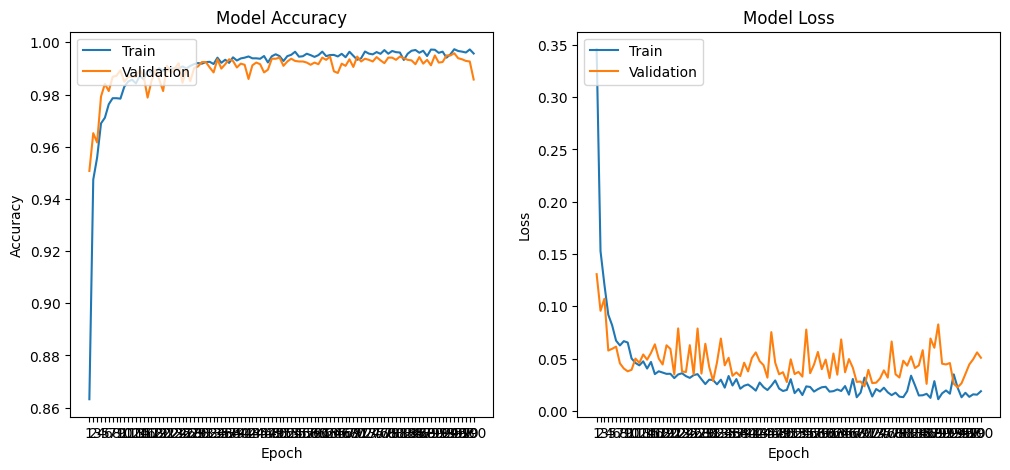

In [ ]:
# !rm -rf export_MNv3L
# !mkdir export_MNv3L
!mkdir export_MNv3L
epochs = 100
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch,
    epochs=epochs,
    callbacks=[custom_checkpoint_callback]
)

In [ ]:
with open('history.json', 'w') as f:

    json.dump(history.history, f)

In [ ]:
!rm -r /content/export_MNv3L/confusion*
!rm -r /content/export_MNv3L/.ipynb_checkpoints
!rm /content/export_MNv3L/result_with_metrics.csv
!rm /content/export_MNv3L/training_and_validation_metrics.png
!rm /content/export_MNv3L/history.json

with open("/content/history.json", 'r') as file:
    history = json.load(file)
modeldir = "export_MNv3L"
test_dir = "/content/eyegaze/test"
total_epoch = epochs
model_filenames = [f'{modeldir}/epoch{epoch}' for epoch in range(1, total_epoch+1)]

# Prepare Test Subset
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Master dictionary
master_dict = {}

# Create Confusion Matrix (Visualization)
def create_cm(cm, modelname: str):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.savefig(f'export_MNv3L/cm_{modelname[18:]}.png', bbox_inches='tight')
    plt.close()

def cm_analyze(test_generator, model, modelname, index):
    # Load Model and initialize a dictionary
    model = tf.keras.models.load_model(model)
    output_dict = {}

    # Process to prepare for creating confusion matrix and calculate precision, recall and f1 score
    test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
    predictions = model.predict(test_generator, steps=test_steps_per_epoch)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    cm = confusion_matrix(true_classes, predicted_classes)
    create_cm(cm, modelname)

    # Calculating precision, recall and f1 score then store inside a dictionary
    report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
   for key, value in report.items():
        if isinstance(value, dict):
            for metric, score in value.items():
                if metric in ['precision', 'recall', 'f1-score']:
                    new_key = f'{metric}_{key}'
                    output_dict[new_key] = score

    # Calculate accuracy and loss from test dataset also append accuracy and loss from train and validation dataset
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)
    output_dict.update({"train_loss": history['loss'][index]})
    output_dict.update({"train_acc": history['accuracy'][index]})
    output_dict.update({"val_loss": history['val_loss'][index]})
    output_dict.update({"val_acc": history['val_accuracy'][index]})
    output_dict.update({"test_loss": test_loss})
    output_dict.update({"test_acc": test_acc})
    return output_dict

# Process all models available
for i, model in enumerate(tqdm(model_filenames)):
    master_dict.update({f"{model[13:]}": cm_analyze(test_generator, model, model, i)})

# Save the DataFrame to a CSV file
df = pd.DataFrame.from_dict(master_dict, orient='index')
df_formatted = df.applymap(lambda x: f"{x:.4f}" if isinstance(x, float) else x)
csv_file_path = '/content/export_MNv3L/result.csv'
df.to_csv(csv_file_path)

In [ ]:
# Save the DataFrame to a CSV file
df = pd.DataFrame.from_dict(master_dict, orient='index')
csv_file_path = '/content/export_MNv3L/result.csv'
df.to_csv(csv_file_path)

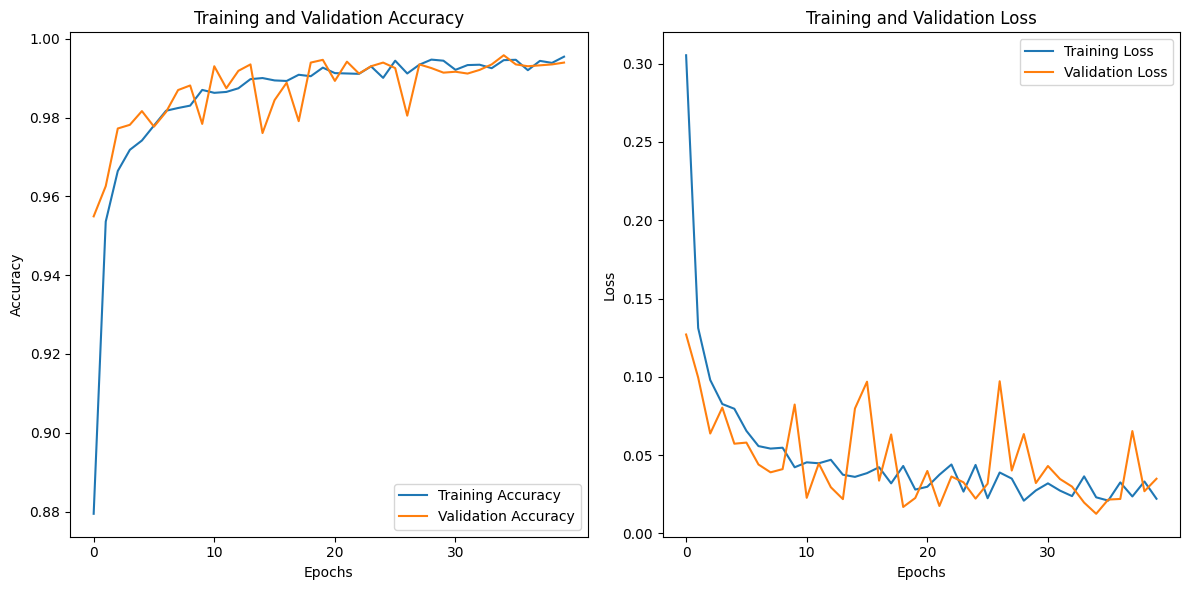

In [ ]:
import matplotlib.pyplot as plt

# Assuming history is the object returned by model.fit()
history_dict = history.history  # Access the history attribute to get the dictionary of metrics

# Now you can use history_dict to plot your metrics
plt.figure(figsize=(12, 6))

# Number of epochs
num_epochs = len(history_dict['accuracy'])

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(0, num_epochs, 10))  # Set x-axis ticks at intervals of 10
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0, num_epochs, 10))  # Set x-axis ticks at intervals of 10
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()

# Save the plot to the 'export_MNv3L' directory
plt.savefig('export_MNv3L/training_and_validation_metrics.png')

plt.show()


In [ ]:
# !tar -zxvf /content/drive/MyDrive/Skripsi/model/export_MNv3S.tar.gz
# unzip("/content/drive/MyDrive/Skripsi/model/export_MNv3L.zip", "/content/export_MNv3L")

In [ ]:
!rm -r /content/export_MNv3S/.ipynb_checkpoints
# Load the trained model
modeldir = "/content/export_MNv3L"

# def classify_image(img_path, model):
#     # Load and preprocess the image
#     img = image.load_img(img_path, target_size=(224, 224))
#     img_array = image.img_to_array(img)
#     img_array = img_array / 255.0  # Normalize to [0,1]
#     img_array = np.expand_dims(img_array, axis=0)  # Create a batch of 1 image

#     # Make predictions
#     predictions = model.predict(img_array)
#     predicted_class_index = np.argmax(predictions, axis=1)[0]
#     predicted_class_probability = predictions[0][predicted_class_index]
#     return predicted_class_index, predicted_class_probability

def classify_image(img_path, model, bias_class_index=3, bias_factor=2):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch of 1 image

    # Make predictions
    predictions = model.predict(img_array)

    # Apply bias to the targeted class
    predictions[0][bias_class_index] *= bias_factor

    # Get the index of the highest probability class after biasing
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    # Normalize the probabilities so they sum to 1
    predictions = predictions / np.sum(predictions)
    predicted_class_probability = predictions[0][predicted_class_index]

    return predicted_class_index, predicted_class_probability

for item in os.listdir(f"{modeldir}"):
  if os.path.isdir(os.path.join(modeldir, item)):
    print(f"\n{item}")
    model = tf.keras.models.load_model(f'{modeldir}/{item}')

    # img_paths1 = [
    #     '/content/drive/MyDrive/Skripsi/testing/close.png',
    #     '/content/drive/MyDrive/Skripsi/testing/forward.png',
    #     '/content/drive/MyDrive/Skripsi/testing/left.png',
    #     '/content/drive/MyDrive/Skripsi/testing/right.png',
    # ]

    # img_paths2 = [
    #     '/content/eyegaze/test/close/close104.png',
    #     '/content/eyegaze/test/forward/forward101.png',
    #     '/content/eyegaze/test/left/left104.png',
    #     '/content/eyegaze/test/right/right104.png'
    # ]
    special = [
        '/content/ROI_screenshot_08.11.2023.png',
        '/content/ROI_screenshot_09.11.2023.png'
    ]

    # print("##########Test1##########")
    # for img_path in img_paths1:
    #     result = classify_image(img_path, model)
    #     print(f"Predicted class for image: {result}")

    # print("##########Test2##########")
    # for img_path in img_paths2:
    #     result = classify_image(img_path, model)
    #     print(f"Predicted class for image: {result}")
    print("##########Special Test##########")
    for img_path in special:
        result = classify_image(img_path, model)
        print(f"Predicted class for image: {result}")

In [ ]:
modeldir = "/content/export_MNv3L"
item = "50_best"

model = tf.keras.models.load_model(f'{modeldir}/{item}')
def classify_image(img_path, model):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch of 1 image

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_probability = predictions[0][predicted_class_index]

    return predicted_class_index, predicted_class_probability
dir = "/content/eyegaze/test"
for cls in os.listdir(dir):
  print("-"*50)
  print(cls)
  for img in os.listdir(f"{dir}/{cls}"):
    # print(img)
    result = classify_image(f"{dir}/{cls}/{img}", model)
    print(result)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

modeldir = "/content/export_MNv3L"
item = "50_best"

model = tf.keras.models.load_model(f'{modeldir}/{item}')

# def classify_image(img_path, model):
    # ... [your existing code for classify_image function] ...

dir = "/content/eyegaze/test"

true_labels = []
predicted_labels = []

# Assuming your class labels are integers starting from 0
class_indices = {cls: i for i, cls in enumerate(sorted(os.listdir(dir)))}

for cls in os.listdir(dir):
    for img in os.listdir(f"{dir}/{cls}"):
        result = classify_image(f"{dir}/{cls}/{img}", model)
        predicted_class_index = result[0]

        true_labels.append(class_indices[cls])
        predicted_labels.append(predicted_class_index)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix', y=-0.001)
plt.show()


In [ ]:
# !rm /content/drive/MyDrive/Skripsi/model/export_MNv3L.tar.gz

In [ ]:
# import json
# with open('/content/export_MNv3L/history.json', 'w') as f:
#     json.dump(history.history, f)
zip_folder("/content/export_MNv3L", "/content/drive/MyDrive/Skripsi/model/export_MNv3L.zip")
!du -sh /content/export_MNv3L

Zipping: 100%|██████████| 301/301 [03:46<00:00,  1.33file/s]

4.1G	/content/export_MNv3L


In [ ]:
!du -sh /content/export_MNv3L
!du -sh /content/drive/MyDrive/Skripsi/model/export_MNv3L.zip

2.1G	/content/export_MNv3L
1.7G	/content/drive/MyDrive/Skripsi/model/export_MNv3L.zip


In [ ]:
unzip("/content/drive/MyDrive/Skripsi/model/export_MNv3L.zip","/content/export_MNv3L")
!cp export_MNv3L/history.json history.json

Extracting files: 100%|██████████| 302/302 [00:22<00:00, 13.68it/s]

cp: cannot stat 'export_MNv3L/history.json': No such file or directory


In [ ]:
!cp history.json export_MNv3L/history.json